# Define authorities
The purpose of this file is to create a defined list of authors (twitter accounts) that can be taken as a reference for SDG divulgation.

In [ ]:
# update tweepy to latest version (google colab has an outdated version)
!pip install --upgrade tweepy
# must restart runtime after upgrade

In [ ]:
#imports
import pandas as pd
import csv
import tweepy
import re
import json
import time
import collections

# graphs
import networkx as nx

# drawing
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


*Skip to the graph section if authority candidates have already been collected*

In [ ]:
# load dataset
df =pd.read_csv("drive/My Drive/TFG/Datasets/tweetsSDG_enALL.csv",
                    lineterminator='\n', index_col=0)

df.info()
display(df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1482079 entries, 0 to 1482078
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   twid           1482079 non-null  int64 
 1   authid         1482079 non-null  int64 
 2   created_at     1482079 non-null  object
 3   lang           1482079 non-null  object
 4   like_count     1482079 non-null  int64 
 5   quote_count    1482079 non-null  int64 
 6   reply_count    1482079 non-null  int64 
 7   retweet_count  1482079 non-null  int64 
 8   text           1482079 non-null  object
dtypes: int64(6), object(3)
memory usage: 113.1+ MB


,twid,authid,created_at,lang,like_count,quote_count,reply_count,retweet_count,text
0,638501711070535680,2657143950,2015-09-01 00:00:45+00:00,en,0,0,0,0,From @UGECProject: #urban #SDGs difficult bc u...
1,638502238646878209,597917107,2015-09-01 00:02:51+00:00,en,0,0,0,1,Internet Speech: Is It Free or Not? http://t.c...
2,638502291776126977,2657143950,2015-09-01 00:03:03+00:00,en,0,0,0,0,Applied research needed to test #SDGs in citie...
3,638502519027712000,344831740,2015-09-01 00:03:57+00:00,en,1,0,0,0,"RT @ TriplePundit: For SABMiller, the #SDGs ar..."
4,638502554393927680,1578572066,2015-09-01 00:04:06+00:00,en,0,0,0,0,Thanks @irishmissionun for co-facilitating #SD...


In [ ]:
# Remove text duplicates
print(len(df[df['text'].duplicated()]))
df.drop_duplicates(subset=['text'], inplace=True)
print(len(df[df['text'].duplicated()]))

87708
0


In [ ]:
# Exploration
print('Total number of tweets: ', len(df))
print('Number of different posters: ', df['authid'].nunique())
print('Post per author of the top 10 SDG posters:\n')
display(df['authid'].value_counts().head(10))

Total number of tweets:  1394371
Number of different posters:  184808
Post per author of the top 10 SDG posters:



127923382              19609
3852515774              8998
1497787496              5214
768944238365028353      4987
93223785                4711
2507144761              4658
2438275574              4013
1154381411614416906     3389
981111944009732096      3213
75673231                3069
Name: authid, dtype: int64

#### Sorting the pre-candidates and metrics
Build a sorted list of candidates to explore first. For it we will use the metric of `nposts*nRetweetsTotal`, where `nposts` is the total number of tweets posted with the SDG tag regarding a user and `nRetweetsTotal` is the sum of total retweets generated by all the posts of a user containing the SDG tag.

In [ ]:
display(df['authid'].value_counts().to_frame().rename(columns={'authid':'ntweets'}).head())

In [ ]:
# build the metrics datafeame by author
preCand = df[['authid','retweet_count']].groupby(by='authid').sum() # are sorted by 'authid' by default
# add the number of tweets by user to the dataframe
preCand = preCand.join(df['authid'].value_counts().to_frame().rename(columns={'authid':'ntweets'}))
# Compute and add the multiplication of metrics
preCand['score'] = round(preCand['retweet_count']*preCand['ntweets']/100).astype(int)

# display resulting dataframe
preCand.sort_values(by='score', ascending=False, inplace=True)
display(preCand.head())

,retweet_count,ntweets,score
authid,,,
1497787496,43426,5214,2264232
20596281,65457,2119,1387034
75673231,35037,3069,1075286
2507144761,20081,4658,935373
3066095291,175800,532,935256


### Tweepy
Use de community developed library tweepy to request information about twitter accounts in order to build a graph.

In [ ]:
# load bearer token
tokens = open('drive/My Drive/TFG/academic research tokens.txt').readline()
bearer_token = re.search('\w+,\s(.+)\s', tokens).group(1)

In [ ]:
# instantiate API endpoint and authenticate
client = tweepy.Client(bearer_token)

Define a list of verified candidates to be authorities. We will choose the first 100 verified accounts that have the most SDG usage and collect information about the accounts such as the usernames. Later on this information will be used to collect the retweets betweet this candidates and build a directed graph.

In [ ]:
# define list of 100 verified accounts by #sdg usage
# information we will be collecting: ['uid', 'username', 'description', 'protected', 'followers', 'tweet_count']
verified_candidates_count = 0
candidates = []

for candidate_id in preCand.index:
  #request user information
  user = client.get_user(id=candidate_id, user_fields=["description,verified,protected,public_metrics"])
  time.sleep(1)# to avoid getting capped at the rate limit

  #check verified status
  if len(user.errors)==0:
    if user.data.verified:
      candidates.append([user.data.id,
                        user.data.username,
                        user.data.description,
                        user.data.protected,
                        user.data.public_metrics['followers_count'],
                        user.data.public_metrics['tweet_count']])
      verified_candidates_count+=1
      # Progress tracker
      if verified_candidates_count%5==0:
        print('Number of verified candidates collected: ', verified_candidates_count)
      if verified_candidates_count >= 100:
        break

Number of verified candidates collected:  5
Number of verified candidates collected:  10
Number of verified candidates collected:  15
Number of verified candidates collected:  20
Number of verified candidates collected:  25
Number of verified candidates collected:  30
Number of verified candidates collected:  35
Number of verified candidates collected:  40
Number of verified candidates collected:  45
Number of verified candidates collected:  50
Number of verified candidates collected:  55
Number of verified candidates collected:  60
Number of verified candidates collected:  65
Number of verified candidates collected:  70
Number of verified candidates collected:  75
Number of verified candidates collected:  80
Number of verified candidates collected:  85
Number of verified candidates collected:  90
Number of verified candidates collected:  95
Number of verified candidates collected:  100


In [ ]:
cand_df = pd.DataFrame(data=candidates, columns=['uid', 'username', 'description', 'protected', 'followers', 'tweet_count'])
cand_df.info()
display(cand_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   uid          100 non-null    int64 
 1   username     100 non-null    object
 2   description  100 non-null    object
 3   protected    100 non-null    bool  
 4   followers    100 non-null    int64 
 5   tweet_count  100 non-null    int64 
dtypes: bool(1), int64(3), object(2)
memory usage: 4.1+ KB


,uid,username,description,protected,followers,tweet_count
0,20596281,UNDP,Working to end poverty for good. Transforming ...,False,1776404,73296
1,3066095291,AminaJMohammed,Deputy Secretary-General of the @UN Amina J Mo...,False,375561,6954
2,281098482,UNDESA,UN DESA assists countries around the world in ...,False,111934,18756
3,260928758,SustDev,Official account of @UNDESA's Division for #SD...,False,235157,15807
4,22972898,SDGaction,Official account of the United Nations SDG Act...,False,137402,17417


In [ ]:
print('Number of private candidates: ', len(cand_df[cand_df['protected']==True]))

Number of private candidates:  0


In [ ]:
# Store the dataset of verified candidates:
cand_df.to_csv('drive/My Drive/TFG/Authority_candidates.csv', index=False)

### Collect retweet information between candidates

In [ ]:
# load candidates (skip if already loaded as a local variable)
cand_df = pd.read_csv('drive/My Drive/TFG/Authority_candidates.csv')
display(cand_df.head())

,uid,username,description,protected,followers,tweet_count
0,20596281,UNDP,Working to end poverty for good. Transforming ...,False,1776404,73296
1,3066095291,AminaJMohammed,Deputy Secretary-General of the @UN Amina J Mo...,False,375561,6954
2,281098482,UNDESA,UN DESA assists countries around the world in ...,False,111934,18756
3,260928758,SustDev,Official account of @UNDESA's Division for #SD...,False,235157,15807
4,22972898,SDGaction,Official account of the United Nations SDG Act...,False,137402,17417


In [ ]:
# collect the graph edge information (reference tweets: retweets, replies and quotes)
# The tweets are collected from the two last weeks of march

def initSquareDict (keys):
  squareDict = {}
  for key in keys:
    squareDict[key] = dict.fromkeys(keys, 0)
  return squareDict

candidate_ids = cand_df['uid'].values
references = initSquareDict(candidate_ids) # poster id to dict of referenced user and count of references

progress_track = 0

for candidate in cand_df['uid']:
  # start request
  try:
    for tweets in tweepy.Paginator(client.get_users_tweets, 
                                    candidate, 
                                    expansions=['referenced_tweets.id.author_id'],
                                    max_results=100,
                                    start_time= '2022-05-17T00:00:00Z', #less recent
                                    end_time= '2022-06-01T00:00:00Z', #most recent
                                    ): 
      # wait 1 sec to avoid getting rate capped
      time.sleep(1)
      

      # store the new data in the dictionary
      if tweets.meta['result_count']>0: # if it has any referenced tweets, then store them
        for user in tweets.includes['users']:
          if user.id in candidate_ids:
            references[candidate][user.id] +=1

  # handling the exceptions
  except tweepy.errors.TweepyException as e:
    print(e)
    if e.args[0][0].code == 429: # Too many requests
      print('Two minute break. Go drink some water.')
      time.sleep(60*2)
    else:
      print('Something has gone wrong. SOS')
      break
  # Progress tracking
  progress_track+=1
  if progress_track%5==0:
    print('-----Number of candidates explored: ', progress_track)


-----Number of candidates explored:  5
-----Number of candidates explored:  10
-----Number of candidates explored:  15
-----Number of candidates explored:  20
-----Number of candidates explored:  25
-----Number of candidates explored:  30
-----Number of candidates explored:  35
-----Number of candidates explored:  40
-----Number of candidates explored:  45
-----Number of candidates explored:  50
-----Number of candidates explored:  55
-----Number of candidates explored:  60
-----Number of candidates explored:  65
-----Number of candidates explored:  70
-----Number of candidates explored:  75
-----Number of candidates explored:  80
-----Number of candidates explored:  85
-----Number of candidates explored:  90
-----Number of candidates explored:  95
-----Number of candidates explored:  100


In [ ]:
# Store the tweet reference matrix to a file:
references_df = pd.DataFrame.from_dict(references)
display(references_df.head())
references_df.to_csv('drive/My Drive/TFG/references.csv')

,20596281,3066095291,281098482,260928758,22972898,39511166,3232924232,105328660,131079801,504914052,...,253137919,2574142189,1244137812,27648752,198573449,216356915,40001204,20646711,1061570058,339754094
20596281,3,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,1,0,0,0
3066095291,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
281098482,0,0,1,1,0,0,0,1,0,0,...,2,0,0,0,0,0,1,0,0,0
260928758,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,1,1,0,0,0
22972898,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


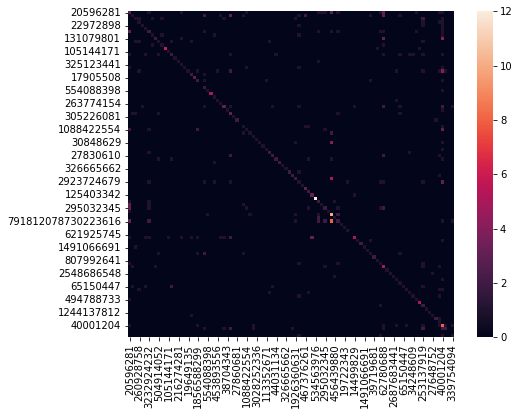

In [ ]:
# print the adjacency matrix
plt.figure(figsize=(8,6))
sns.heatmap(references_df, square=True);

### Build graph from reference tweet information

In [ ]:
# load dataset if not in memory already
references_df = pd.read_csv('drive/My Drive/TFG/references.csv', index_col=0, lineterminator='\n')
# properly format columns
references_df.index = references_df.columns
display(references_df.head())

,20596281,3066095291,281098482,260928758,22972898,39511166,3232924232,105328660,131079801,504914052,...,253137919,2574142189,1244137812,27648752,198573449,216356915,40001204,20646711,1061570058,339754094
20596281,3,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,1,0,0,0
3066095291,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
281098482,0,0,1,1,0,0,0,1,0,0,...,2,0,0,0,0,0,1,0,0,0
260928758,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,1,1,0,0,0
22972898,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


In [ ]:
# Construct graph
G = nx.from_pandas_adjacency(references_df, create_using=nx.DiGraph)
G.name = 'SDG authorities tweet references'
print(nx.info(G))
print(G['281098482']['253137919']['weight'])

DiGraph named 'SDG authorities tweet references' with 100 nodes and 341 edges
2


In [ ]:
# Rename the labels from ids to usernames
mapping = dict(zip([str(id) for id in cand_df['uid'].values], cand_df['username'].values)) # dict 
G = nx.relabel_nodes(G, mapping, copy=False)

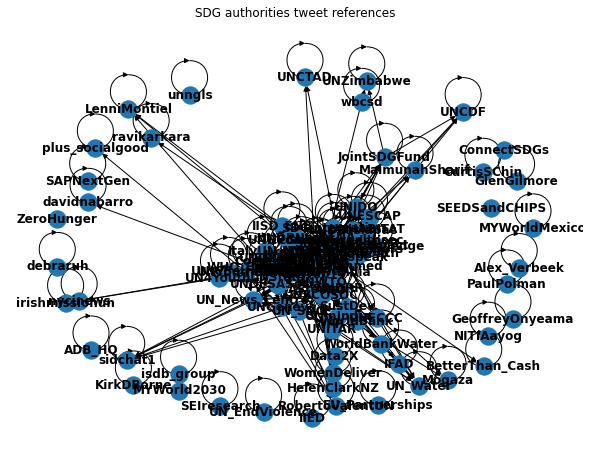

In [ ]:
# Draw the graph
def draw_graph (g):
  plt.figure(figsize=(8,6))
  nx.draw(g, with_labels=True, font_weight='bold')
  plt.title(g.name)
  plt.show()

draw_graph(G)

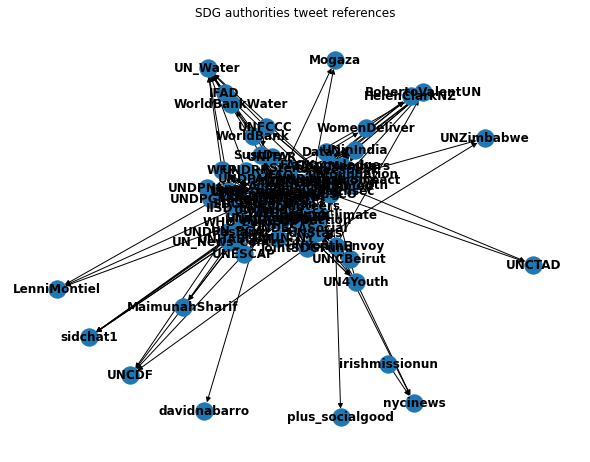

In [ ]:
# remove self loops
G.remove_edges_from(nx.selfloop_edges(G))
# remove disconnected subgraphs (including single nodes)
# The line below returns the largest connected component
largCC_nodes = max(nx.weakly_connected_components(G), key=len)
Gmain = G.subgraph(largCC_nodes)
draw_graph(Gmain)

In [ ]:
# Apply pagerank to the main connectec component
pr = nx.pagerank(Gmain, alpha=0.9)

# Apply HITS
h, a = nx.hits(Gmain)

In [ ]:
# dataset with scores by pagerank
ranks = pd.DataFrame.from_dict(pr, orient='index', columns=['PageRank'])
# join hubs and authorities
ranks = ranks.join(pd.DataFrame.from_dict(h, orient='index', columns=['Hub']))
ranks = ranks.join(pd.DataFrame.from_dict(a, orient='index', columns=['Auth']))

# show results
ranks.sort_values(by='PageRank', ascending=False, inplace=True)
display(ranks.head(25))

,PageRank,Hub,Auth
UNBiodiversity,0.085260,0.015712,0.117600
UNDP,0.071354,0.072492,0.091977
UNDP4Youth,0.055212,0.008768,0.020115
SEforALLorg,0.053700,0.006222,0.204715
ItalyUN_NY,0.042330,0.001226,0.023236
UNDRR,0.041965,0.005022,0.073971
UNDPClimate,0.041838,0.142890,0.017797
UNDPAfrica,0.039319,0.008842,0.043010
UN_Water,0.038388,-0.000000,0.016923
ASteiner,0.031904,0.047956,0.052209


In [ ]:
print([val for k, val in pr.items()])

[0.018909677510720767, 0.02484393603374838, 0.010962880443966077, 0.002909029266189785, 0.0033697434833527447, 0.005339570637556441, 0.012859753891721143, 0.010582534435677908, 0.009205903388151755, 0.03931903916457034, 0.005260397052002144, 0.003303585515029467, 0.004162205537278451, 0.05369953298780955, 0.012823851544914375, 0.0037399549876592783, 0.007165930262192227, 0.07135413295083586, 0.009427388646555505, 0.0073219193437286, 0.003791374892453934, 0.002909029266189785, 0.002909029266189785, 0.014290221066184692, 0.004291171917678664, 0.008324002871755672, 0.0033601104559405374, 0.010462869454177171, 0.010783935730737822, 0.002909029266189785, 0.01358342895384369, 0.008961950606897414, 0.03190372388078825, 0.013207754649332729, 0.002909029266189785, 0.002909029266189785, 0.006123667460281666, 0.006686258753020757, 0.0075073249717035615, 0.005527246101968654, 0.005512804895997449, 0.002909029266189785, 0.0031104305612496977, 0.00632037261616823, 0.005165453123391483, 0.00290902926

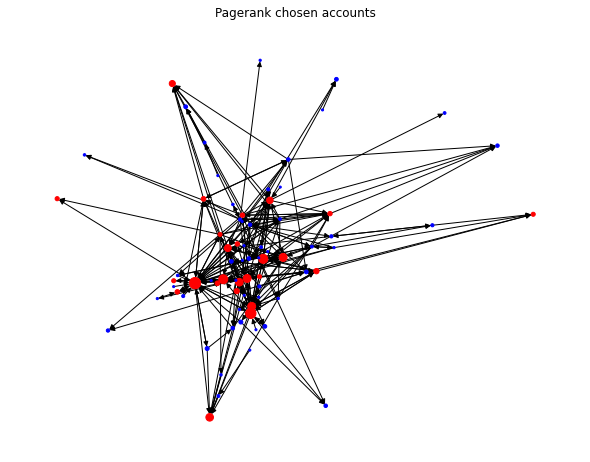

In [ ]:
# show Pagerank result in a draw
plt.figure(figsize=(8,6))
nx.draw(Gmain, node_size=[val*1500 for k, val in pr.items()],
        font_weight='bold', 
        node_color=['red' if val>0.01078 else 'blue' for k, val in pr.items()])
plt.title('Pagerank chosen accounts')
plt.show()

**CONCLUISON**: Due to the missing links and accounts sorrounding the Graph of accounts, Pagerank and HITS lead to misleading rankings, having a bias towards accounts that are linked by the cluster of the Graph and that in turn would link to accounts that are outside of the graph and therefore are missrepresented. In order to tackle this issue, a centrality algorithm may suit the problem better.

### Wrap and store enriched dataset TOP 25 accounts

In [ ]:
# enrich with other fields
top25 = ranks.head(25)
top25 = top25.join(cand_df.set_index('username'))
print(top25.info())
display(top25.head())

<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, UNBiodiversity to UNESCO
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PageRank     25 non-null     float64
 1   Hub          25 non-null     float64
 2   Auth         25 non-null     float64
 3   uid          25 non-null     int64  
 4   description  25 non-null     object 
 5   protected    25 non-null     bool   
 6   followers    25 non-null     int64  
 7   tweet_count  25 non-null     int64  
dtypes: bool(1), float64(3), int64(3), object(1)
memory usage: 2.1+ KB
None


,PageRank,Hub,Auth,uid,description,protected,followers,tweet_count
UNBiodiversity,0.085260,0.015712,0.117600,40001204,Tweets from the Secretariat of the Convention ...,False,130459,62925
UNDP,0.071354,0.072492,0.091977,20596281,Working to end poverty for good. Transforming ...,False,1776404,73296
UNDP4Youth,0.055212,0.008768,0.020115,3291441743,@UNDP works with & for #Youth worldwide to ach...,False,84584,15109
SEforALLorg,0.053700,0.006222,0.204715,314125926,SEforALL works in partnership with the @UN and...,False,57363,25901
ItalyUN_NY,0.042330,0.001226,0.023236,253137919,Official profile of Italian Mission to the UN ...,False,25638,29835


In [ ]:
# Store the dataset
top25.to_csv('drive/My Drive/TFG/top25.csv')